In [1]:
"""
Created on May 4th, 2023
Author: Pair Phongphaew 
Reference from @author: Kevin Taylor
"""
# computation packages
import numpy as np
import pandas as pd
from math import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [2]:
import requests
import pandas as pd

# Download data
url = 'https://raw.githubusercontent.com/kevintaylor99/Forecasting-Project-1/main/Raw%20Data/weekly_usage.csv'
response = requests.get(url)
data = response.content.decode('utf-8')

# Save data to CSV file
with open('weekly_usage.csv', 'w') as f:
    f.write(data)

# Load data into pandas DataFrame
df = pd.read_csv('weekly_usage.csv')


In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy import signal
from math import *


def create_kwh_dataframe(df):
    """
    Processes the raw weekly usage data for an account
    into useable ts data to fit a model

    Parameters
    ----------
    df (pd.DataFrame) - pandas DataFrame of weekly usage

    Returns
    -------
    df_out (pd.DataFrame) - pandas DataFrame with Datetime as index
    """
    df_out = df.copy(deep = True)
    df_out.drop(df_out[df_out.value==0].index, inplace = True) # for accounts not yet created, their values are 0
    df_out.set_index( # set the index as a datetime from year and week
        pd.to_datetime([datetime.date.fromisocalendar(year, week, 1) for year, week in zip(df_out.year, df_out.week)]),
        inplace = True
    )
    df_out.drop(columns = ['t', 'week', 'year'], inplace = True) # drop the rest of the columns other than the value in kwh
    df_out.drop(min(df_out.index), inplace = True) # drop the first week, may be incomplete data
    df_out.drop(max(df_out.index), inplace = True) # drop the last week, may be incomplete data
    return df_out

def ts_plots(df, auto_lags):
    """
    Plots the timeseries, autocorrelation and PSD and prints the highest PSD period

    Parameters
    ----------
    df (pd.DataFrame) - pandas DataFrame with a DatetimeIndex and a column named 'value'
    auto_lags (int) - the number of autocorrelation lags to plot, maxlags parameter in ax.acorr function

    Returns
    -------
    """
    # Overall ts plot
    plt.figure(figsize=(10, 7))
    fig, ax = plt.subplots()
    plt.plot(df.value)
    plt.ylabel('Value')
    plt.xlabel('Time t')
    plt.legend(['Value'])
    plt.grid(True)
    plt.show()

    # Autocorrelation
    plt.figure(figsize=(10, 7))
    fig, ax = plt.subplots()
    ax.acorr(df.value.values ,maxlags = auto_lags)
    plt.grid(which='minor')
    plt.legend(['$R_X$(\u03C4)'],loc='upper left')
    plt.xlabel('\u03C4')
    ax.grid(True, which='both')
    plt.tight_layout()
    plt.show()

    # Overall PSD for all accounts combined
    freqs, psd = signal.welch(df.value.values)
    fig, ax = plt.subplots()
    ax.plot(freqs, psd)
    plt.grid(which='minor')
    plt.legend(['PSD'])
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    ax.grid(True, which='both')
    plt.tight_layout()
    plt.show()
    print('Max Power at period {}'.format(1/freqs[psd == max(psd)][0]))
    return

def train_test_split(df, n_test, n_validation):
    """
    Split the train and test data, maintaining the order
    Splits the test set into three equal parts, returns all 5 DataFrames

    Parameters
    ----------
    df (pd.DataFrame) - input timeseries DataFrame
    n_test (int) - number of test points
    n_validation (int) - number of validation points

    Returns
    -------
    Five DataFrames corresponding to train, validation, and test 1, 2, 3
    """
    test_set = df[-n_test:]
    test_thirds = round(1/3*len(test_set))
    return df[:-n_validation-n_test], df[-n_validation-n_test:-n_test], test_set[:-2*test_thirds], test_set[-2*test_thirds:-test_thirds], test_set[-test_thirds:]

def MAPE(actual, predicted):
    """
    Measure the mean absolute percentage error (MAPE)
    """
    return np.mean(np.abs(actual-predicted)/actual)



In [4]:
weekly_usage = pd.read_csv(
    'weekly_usage.csv',
    index_col = 0
    ) # read the pre-processed file
weekly_overall = create_kwh_dataframe(weekly_usage) # apply processing function to convert to ts DataFrame
weekly_overall['week'] = weekly_overall.index 
weekly_overall = weekly_overall.groupby('week').mean() # group for all accounts combined, mean usage in kWh

<Figure size 1000x700 with 0 Axes>

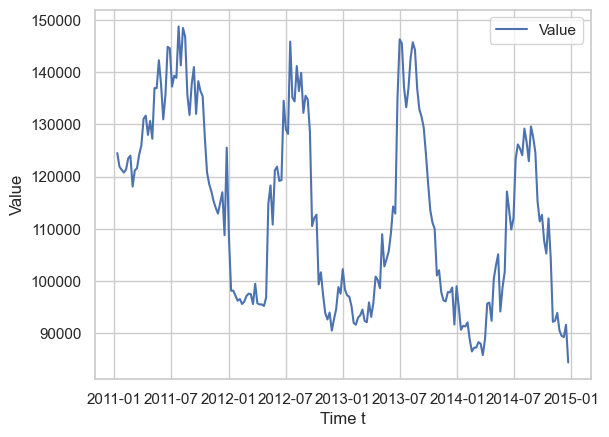

<Figure size 1000x700 with 0 Axes>

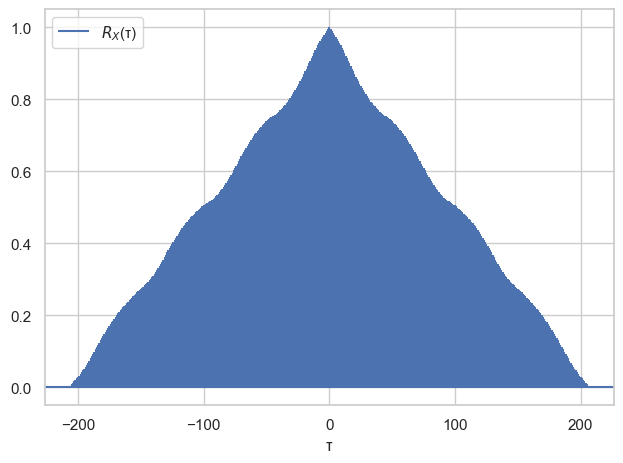

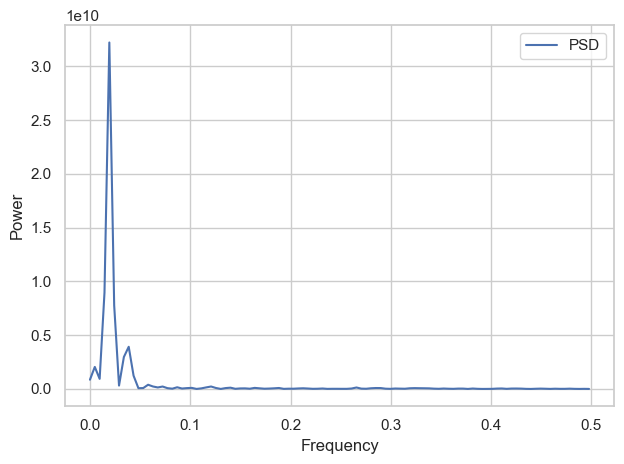

Max Power at period 51.75


In [5]:
ts_plots(weekly_overall, auto_lags = None) # Plot the timeseries, autocorrelation and PSD

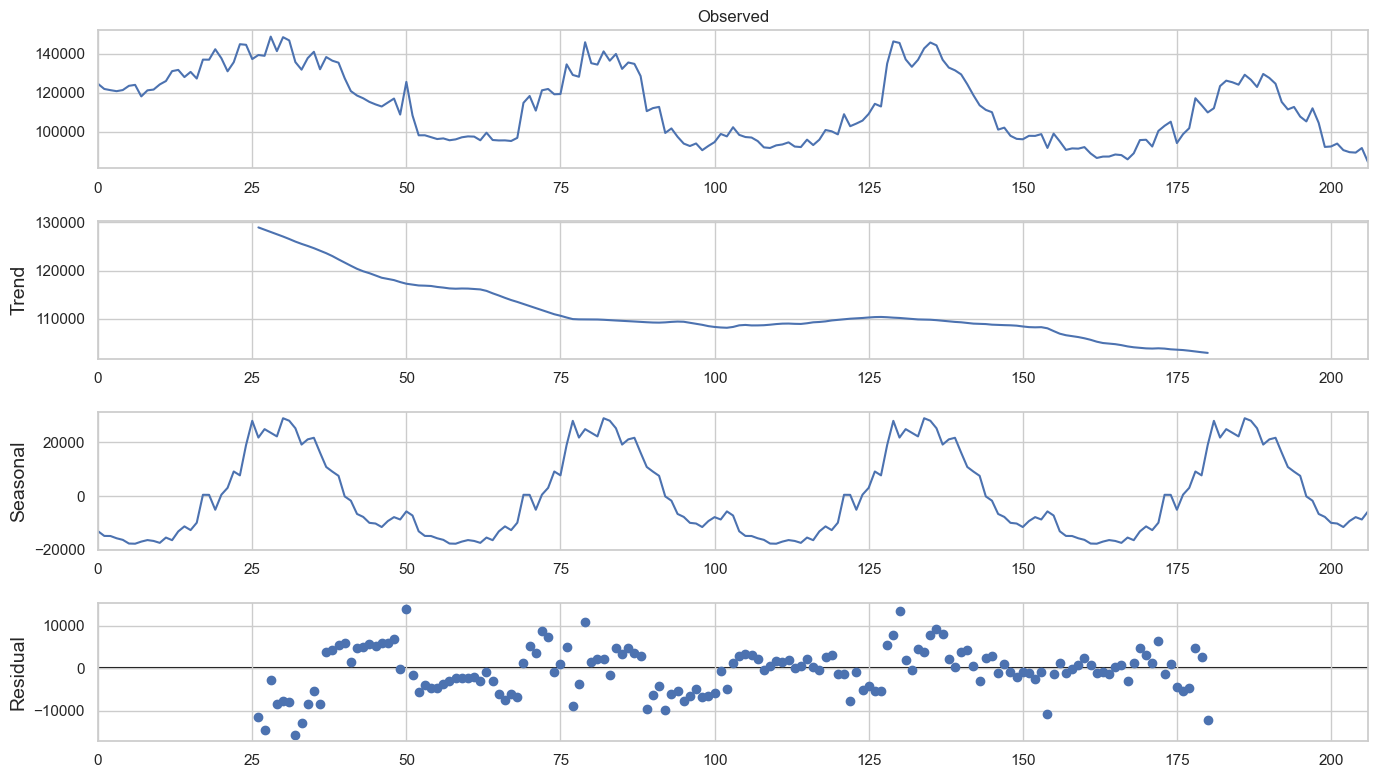

In [6]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=14)
result = seasonal_decompose(weekly_overall.value.values, period = 52, model='additive') # seasonal decomposition of overall ts
fig = result.plot()
# Appears to have 1st order trend with seasonal component, period of 52

In [7]:
weekly_overall

,value
week,
2011-01-10,124484.360870
2011-01-17,121892.405297
2011-01-24,121279.153628
2011-01-31,120760.310694
2011-02-07,121333.428380
...,...
2014-11-24,90532.526313
2014-12-01,89480.877319
2014-12-08,89259.279692


Training Using Transformers

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler


# Split data into train and test sets
train_size = int(len(weekly_overall) * 0.8)
train_df = weekly_overall[:train_size]
test_df = weekly_overall[train_size:]

# Scale data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df.values)
test_data = scaler.transform(test_df.values)

# Define hyperparameters
input_dim = 1
output_dim = 1
num_layers = 2
num_heads = 4
hidden_dim = 16
lr = 0.001
batch_size = 16
num_epochs = 200

# Define PyTorch dataset and dataloader
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __getitem__(self, index):
        x = self.data[index:index+self.seq_len, :]
        y = self.data[index+self.seq_len, :]
        return x, y

    def __len__(self):
        return len(self.data) - self.seq_len

train_dataset = TimeSeriesDataset(train_data, seq_len=1)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define transformer model
class TransformerForecasting(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, num_heads, hidden_dim):
        super(TransformerForecasting, self).__init__()
        self.num_layers = num_layers
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_dim, num_heads),
            num_layers=num_layers)
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)
        x = self.output(x[:, -1, :])
        return x

model = TransformerForecasting(input_dim, output_dim, num_layers, num_heads, hidden_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train the model
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(x.float())
        loss = criterion(output, y.float())
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")





Epoch 0, Loss 0.17138856649398804
Epoch 10, Loss 0.004727250896394253
Epoch 20, Loss 0.006438091397285461
Epoch 30, Loss 0.00843986589461565
Epoch 40, Loss 0.0007622700650244951
Epoch 50, Loss 0.0025427781511098146
Epoch 60, Loss 0.001972468104213476
Epoch 70, Loss 0.0017566855531185865
Epoch 80, Loss 0.002744411351159215
Epoch 90, Loss 0.0128187146037817
Epoch 100, Loss 0.00896450411528349
Epoch 110, Loss 0.0018996859434992075
Epoch 120, Loss 0.007644830271601677
Epoch 130, Loss 0.004958962090313435
Epoch 140, Loss 0.004482320509850979
Epoch 150, Loss 0.0005593214882537723
Epoch 160, Loss 0.012050041928887367
Epoch 170, Loss 0.008726891130208969
Epoch 180, Loss 0.004122621845453978
Epoch 190, Loss 0.004484871402382851


Test the data

In [22]:
test_dataset = TimeSeriesDataset(test_data, seq_len=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
N = len(test_dataset)
# Evaluate the model
model.eval()
y_predict = torch.empty((0,1))
target =torch.empty((0,1))
#print(y_predict.shape)
for epoch in range(1):
    for i, (x, y) in enumerate(test_dataloader):
        output = model(x.float())
        
        y_predict = torch.cat((y_predict,output),dim = 0)
        target = torch.cat((target,y),dim = 0)
      
        

# Invert scaling
test_output = scaler.inverse_transform(y_predict.detach())
test_target = scaler.inverse_transform(target.detach())
#print(test_output.shape)
#print(test_target.shape)


Finding the overall MAPE for each test set 

In [25]:

mape = MAPE(test_target,test_output)
print(mape)

mape1 = MAPE(test_target[:14],test_output[:14])
mape2 = MAPE(test_target[14:28],test_output[14:28])
mape3 = MAPE(test_target[28:],test_output[28:])

print('mape1', mape1)
print('mape2', mape2)
print('mape3',mape3)

print('mean_mape',(mape1+mape2+mape3)/3)

0.046037244362385286
mape1 0.04978474693226302
mape2 0.04169099547214757
mape3 0.046682048092003756
mean_mape 0.04605259683213812


Text(0.5, 1.0, 'Prediction VS Groundtruth')

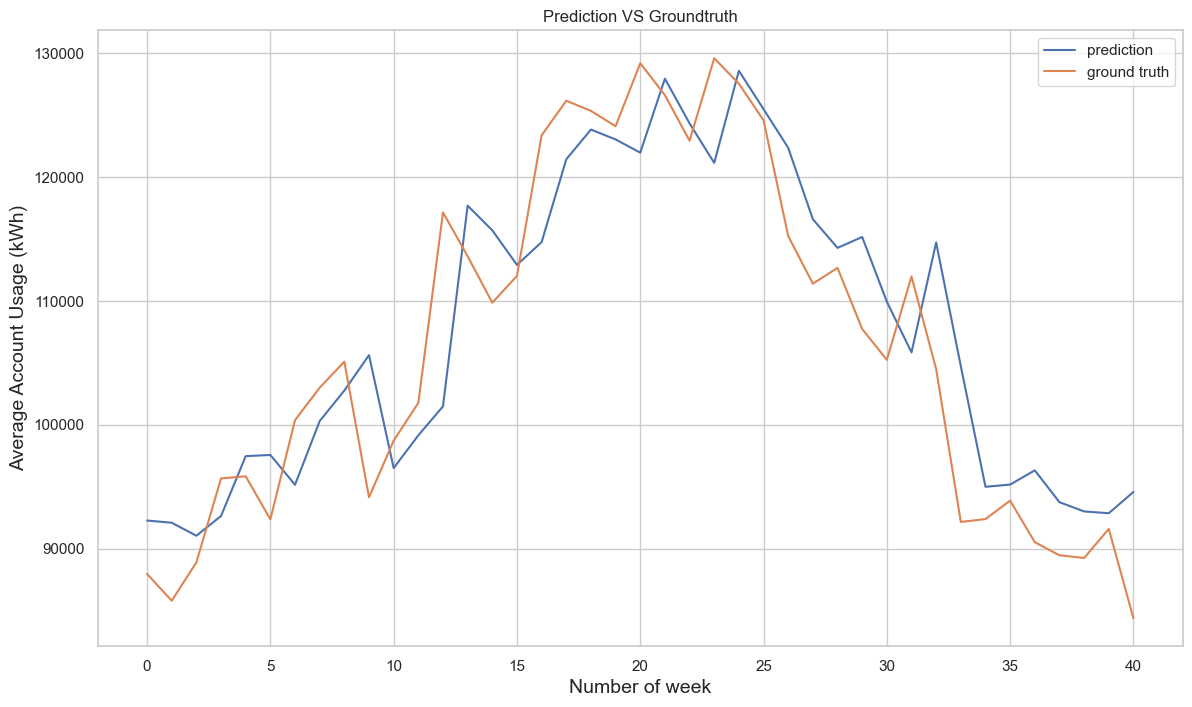

In [11]:
plt.figure()
plt.plot(test_output,label = 'prediction')
plt.plot(test_target,label = 'ground truth')
plt.legend()
plt.xlabel('Number of week')
plt.ylabel('Average Account Usage (kWh)')
plt.title('Prediction VS Groundtruth')

Box Plots

In [12]:
all_MAPE = []
for i in range(len(test_output)):
    all_MAPE.append(MAPE(test_target[i],test_output[i]))
MAPE_set1 = all_MAPE[:14]
MAPE_set2 = all_MAPE[14:28]
MAPE_set3 = all_MAPE[28:]

In [13]:

test1 = test_output[:14].flatten()
test2 = test_output[14:28].flatten()
test3 = test_output[28:].flatten()

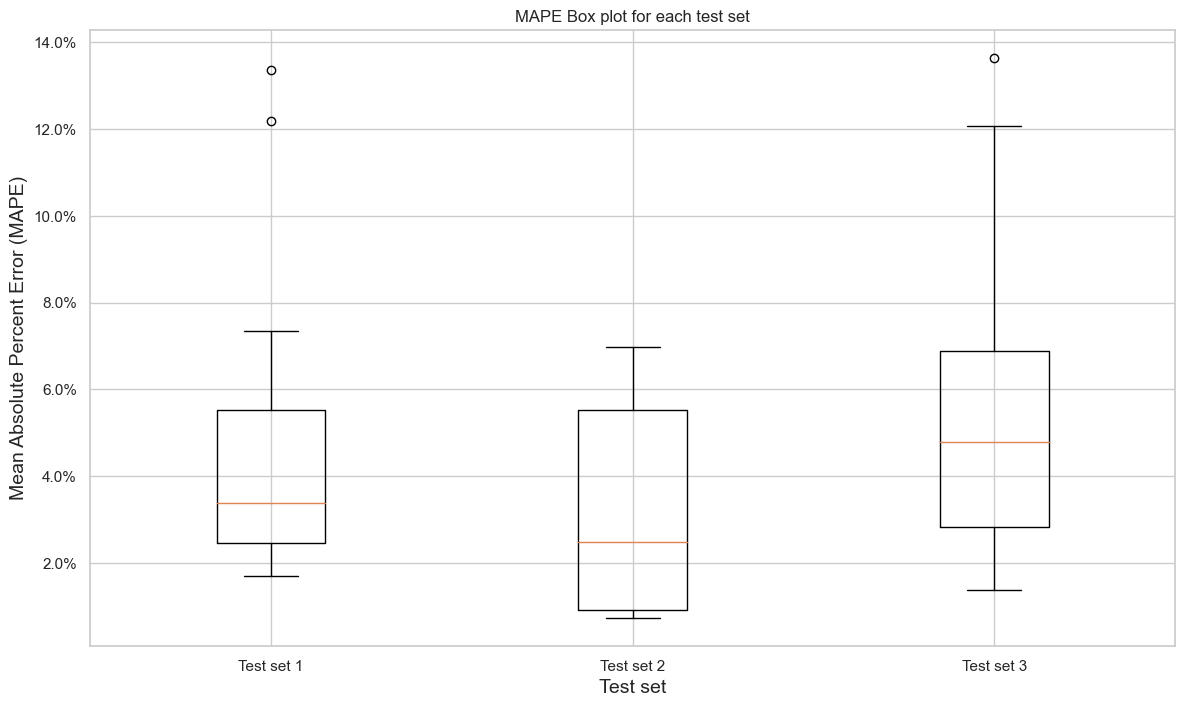

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
# Define the test sets
test_sets = [
    MAPE_set1,
    MAPE_set2,
    MAPE_set3
]

# Create a box plot for each test set
fig, ax = plt.subplots()
ax.boxplot(test_sets)

# Add labels and title
ax.set_title('MAPE Box plot for each test set')
ax.set_xlabel('Test set')
ax.set_ylabel('Mean Absolute Percent Error (MAPE)')

# Set the x-axis tick labels
tick_labels = ['Test set 1', 'Test set 2', 'Test set 3']
ax.set_xticklabels(tick_labels)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
# Show the plot
plt.show()

Finding the highest week of electricity usage

In [15]:
val = max(list(test_output.flatten()))
max_week =list(test_output.flatten()).index(val)
print("Prediction of the highest weekly electricity usuage:", max_week)
print("Corresponding date:", test_df.index[max_week])
val2 =  max(list(test_target.flatten()))
max_week2 =list(test_target.flatten()).index(val2)
print("Ground truth of the highest weekly electricity usuage:", max_week2)
print("Corresponding date:", test_df.index[max_week2])

Prediction of the highest weekly electricity usuage: 24
Corresponding date: 2014-08-25 00:00:00
Ground truth of the highest weekly electricity usuage: 23
Corresponding date: 2014-08-18 00:00:00


The Transformers prediction for the highest usuage is one-week delay comparing to the actual data

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

# Define PyTorch dataset and dataloader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __getitem__(self, index):
        x = self.data[index:index+self.seq_len, :]
        y = self.data[index+self.seq_len, :]
        return x, y

    def __len__(self):
        return len(self.data) - self.seq_len

# Define the neural network architecture
class ElectricityForecastNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElectricityForecastNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size//2)
        self.fc2 = nn.Linear(hidden_size//2, hidden_size//4)
        self.fc3 = nn.Linear(hidden_size//4, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Define PyTorch dataloader
train_dataset = TimeSeriesDataset(train_data, seq_len=1)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the hyperparameters
input_size = 1  # Number of features
hidden_size = 128  # Number of neurons in the hidden layer
output_size = 1  # Number of output values
lr = 0.001  # Learning rate
num_epochs = 200  # Number of training epochs

# Define the model
model = ElectricityForecastNet(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# Train the model
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(x.float()).squeeze(-1)
        loss = criterion(output, y.float())
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")
    

Epoch 0, Loss 0.1111886277794838
Epoch 10, Loss 0.03391961753368378
Epoch 20, Loss 0.03234177082777023
Epoch 30, Loss 0.044874124228954315
Epoch 40, Loss 0.01891598105430603
Epoch 50, Loss 0.02257726341485977
Epoch 60, Loss 0.03447786346077919
Epoch 70, Loss 0.016412094235420227
Epoch 80, Loss 0.010116560384631157
Epoch 90, Loss 0.0013968180865049362
Epoch 100, Loss 0.011937103234231472
Epoch 110, Loss 0.01831526681780815
Epoch 120, Loss 0.009022011421620846
Epoch 130, Loss 0.016480136662721634
Epoch 140, Loss 0.03575889766216278
Epoch 150, Loss 0.004734679125249386
Epoch 160, Loss 0.013591337017714977
Epoch 170, Loss 0.003982204012572765
Epoch 180, Loss 0.03028431348502636
Epoch 190, Loss 0.012257983908057213


In [28]:
test_dataset = TimeSeriesDataset(test_data, seq_len=1)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
N = len(test_dataset)

# Evaluate the model
model.eval()
y_predict = torch.empty([0,1])
target =torch.empty([0,1])

for epoch in range(1):
    for i, (x, y) in enumerate(test_dataloader):
        output = model(x.float()).squeeze(-1)

        y_predict = torch.cat((y_predict,output),dim = 0)
        target = torch.cat((target,y),dim = 0)
      
        

# Invert scaling
test_output = scaler.inverse_transform(y_predict.detach())
test_target = scaler.inverse_transform(target.detach())
#print(test_output.shape)
#print(test_target.shape)

0.044268652516803106
mape1 0.04536753746086286
mape2 0.03014255190369999
mape3 0.05829796169884979
mean_mape 0.044602683687804213


Text(0.5, 1.0, 'NN Prediction VS Groundtruth')

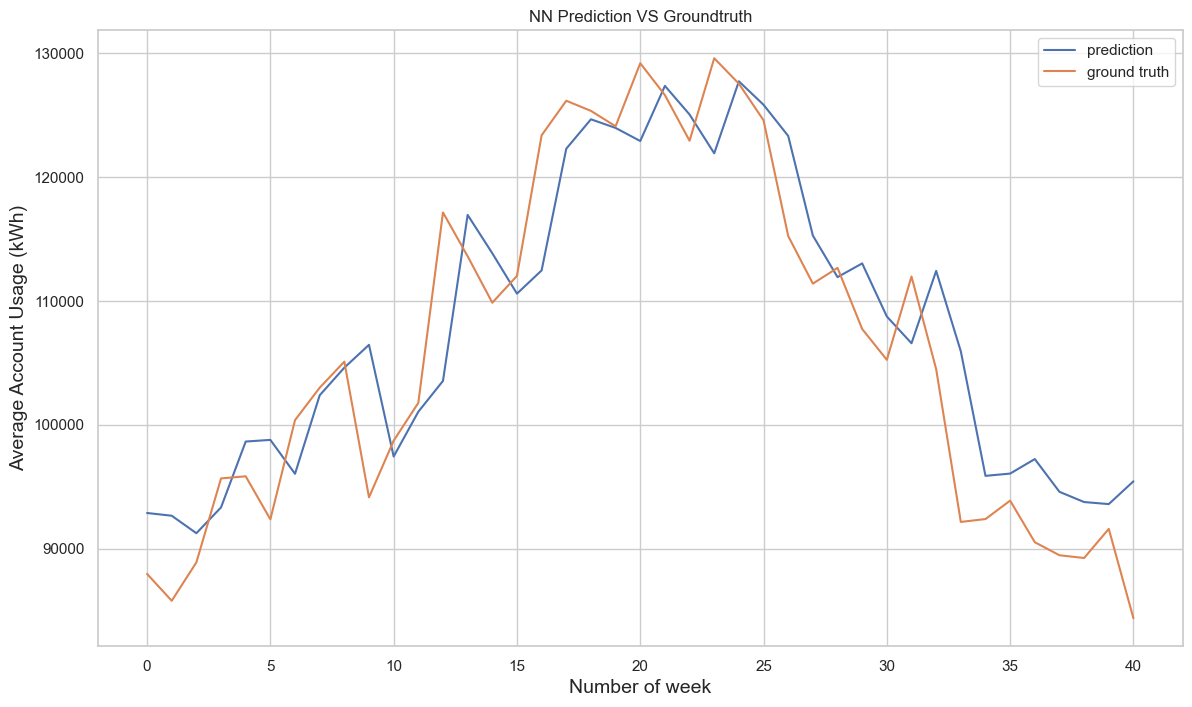

In [29]:
print(MAPE(test_target,test_output))

mape1 = MAPE(test_target[:14],test_output[:14])
mape2 = MAPE(test_target[14:28],test_output[14:28])
mape3 = MAPE(test_target[28:],test_output[28:])

print('mape1', mape1)
print('mape2', mape2)
print('mape3',mape3)

print('mean_mape',(mape1+mape2+mape3)/3)

plt.figure()
plt.plot(test_output,label = 'prediction')
plt.plot(test_target,label = 'ground truth')
plt.legend()
plt.xlabel('Number of week')
plt.ylabel('Average Account Usage (kWh)')
plt.title('NN Prediction VS Groundtruth')

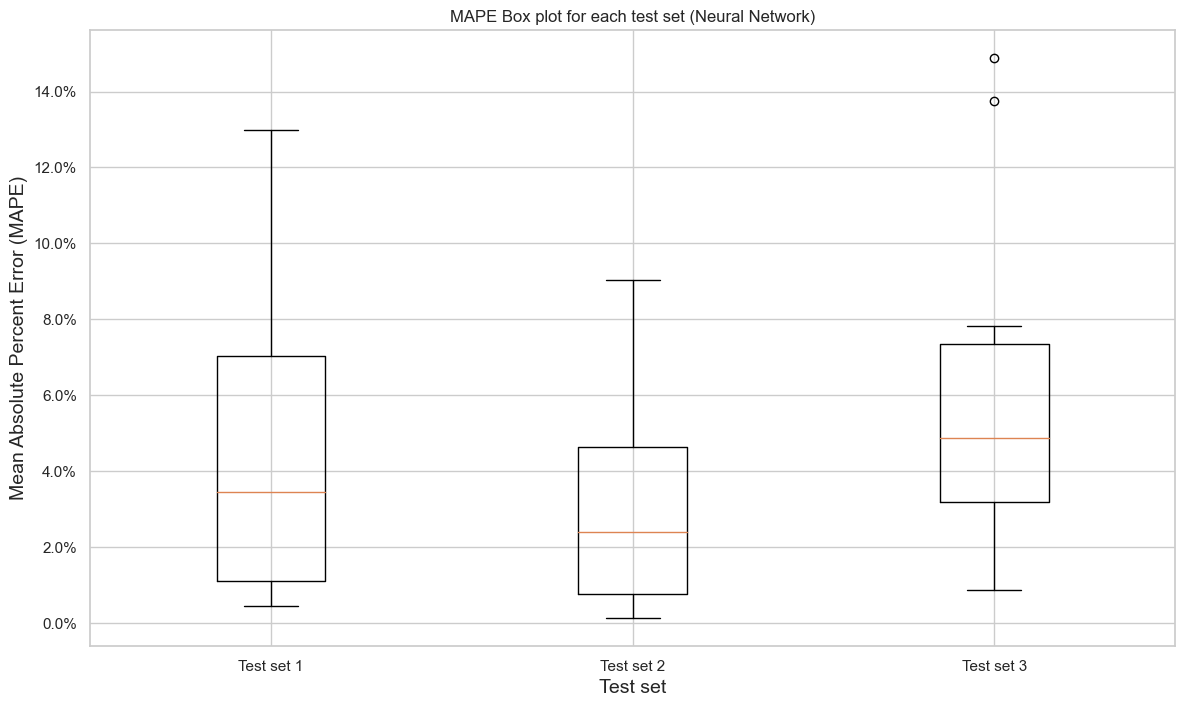

In [19]:
all_MAPE = []
for i in range(len(test_output)):
    all_MAPE.append(MAPE(test_target[i],test_output[i]))
MAPE_set1 = all_MAPE[:14]
MAPE_set2 = all_MAPE[14:28]
MAPE_set3 = all_MAPE[28:]

test1 = test_output[:14].flatten()
test2 = test_output[14:28].flatten()
test3 = test_output[28:].flatten()

# Define the test sets
test_sets = [
    MAPE_set1,
    MAPE_set2,
    MAPE_set3
]

# Create a box plot for each test set
fig, ax = plt.subplots()
ax.boxplot(test_sets)

# Add labels and title
ax.set_title('MAPE Box plot for each test set (Neural Network)')
ax.set_xlabel('Test set')
ax.set_ylabel('Mean Absolute Percent Error (MAPE)')

# Set the x-axis tick labels
tick_labels = ['Test set 1', 'Test set 2', 'Test set 3']
ax.set_xticklabels(tick_labels)
ax.set_xticklabels(tick_labels)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
# Show the plot
plt.show()

Finding highest weekly usuage

In [20]:
val = max(list(test_output.flatten()))
max_week =list(test_output.flatten()).index(val)
print("Prediction of the highest weekly electricity usuage:", max_week)
print("Corresponding date:", test_df.index[max_week])
val2 =  max(list(test_target.flatten()))
max_week2 =list(test_target.flatten()).index(val2)
print("Ground truth of the highest weekly electricity usuage:", max_week2)
print("Corresponding date:", test_df.index[max_week2])

Prediction of the highest weekly electricity usuage: 24
Corresponding date: 2014-08-25 00:00:00
Ground truth of the highest weekly electricity usuage: 23
Corresponding date: 2014-08-18 00:00:00
